In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
import re

In [55]:
data=pd.read_csv("Automobile_data.csv",na_values=["?"])

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [57]:
data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [58]:
df=data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

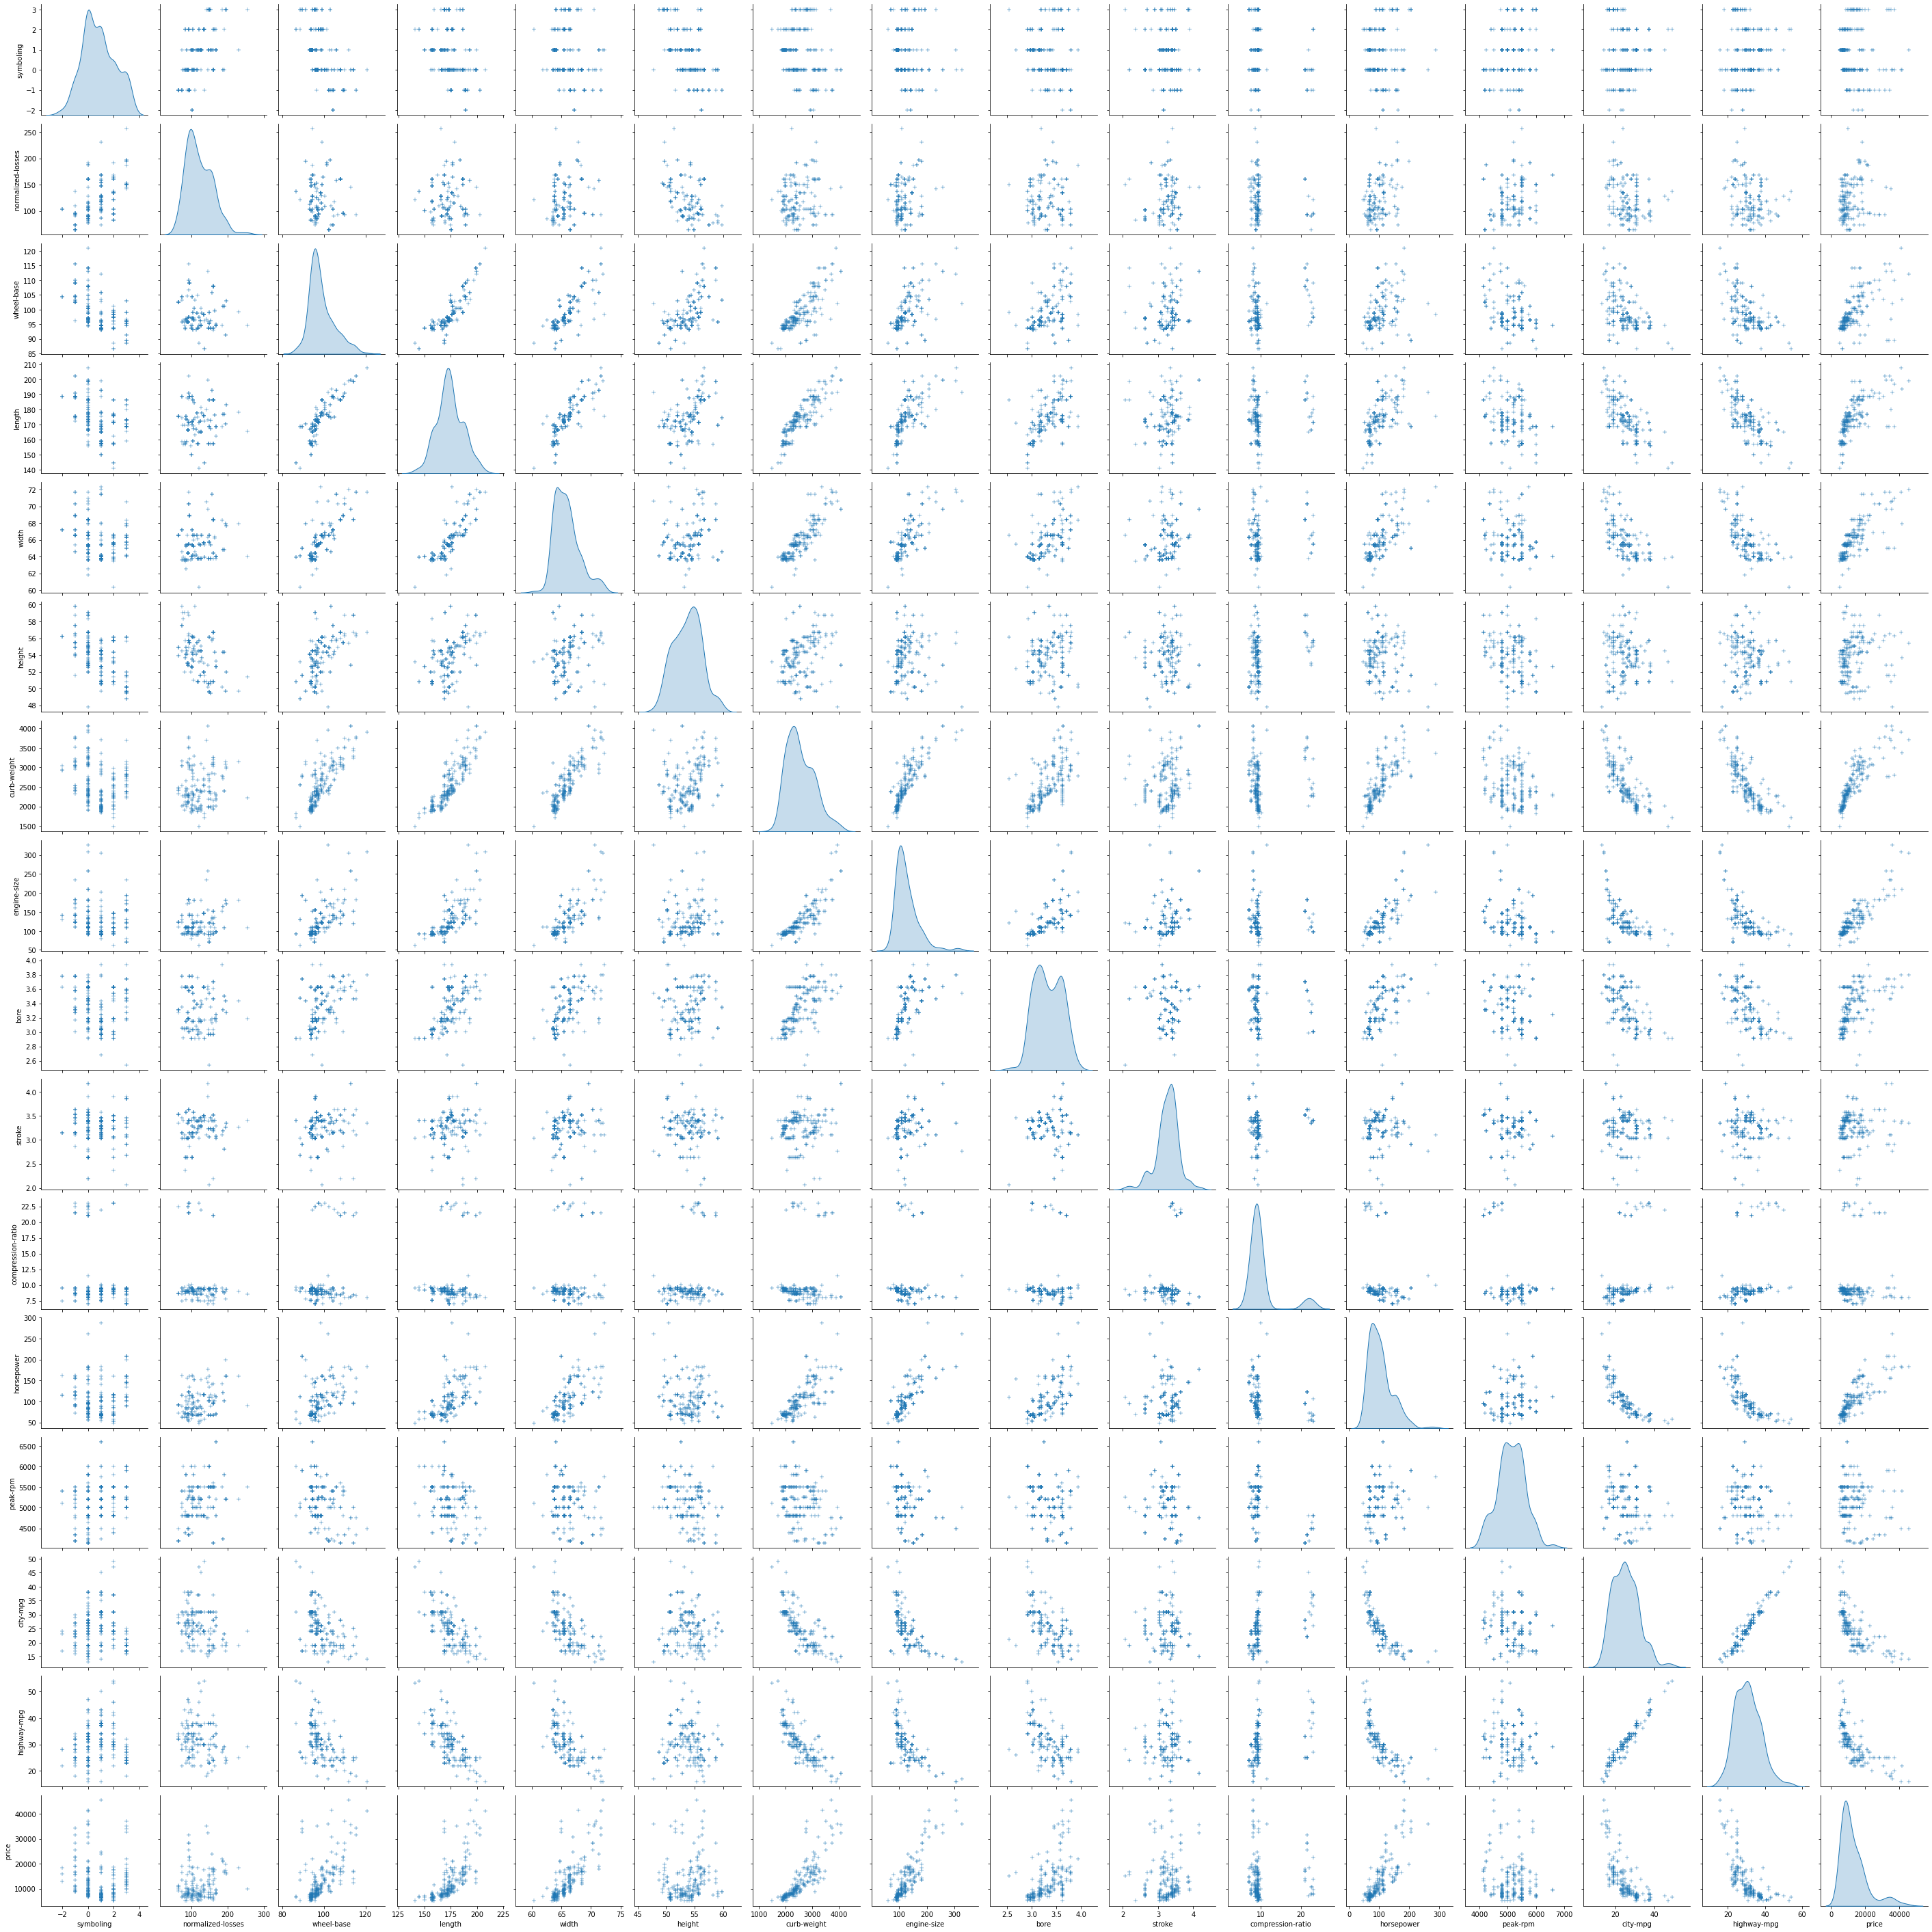

In [59]:
sns.pairplot(data, diag_kind='kde', markers='+')

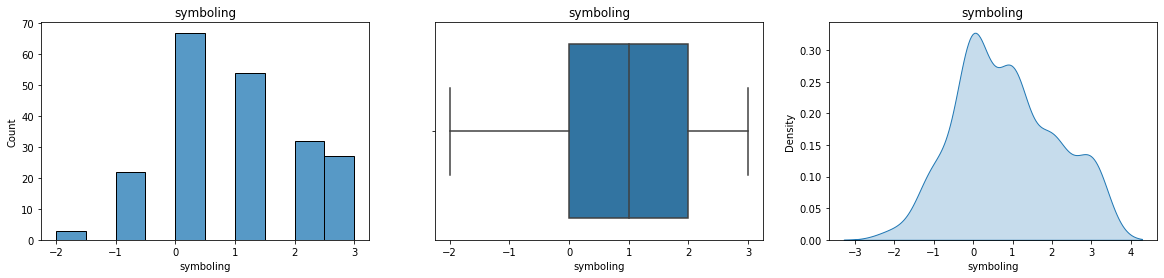

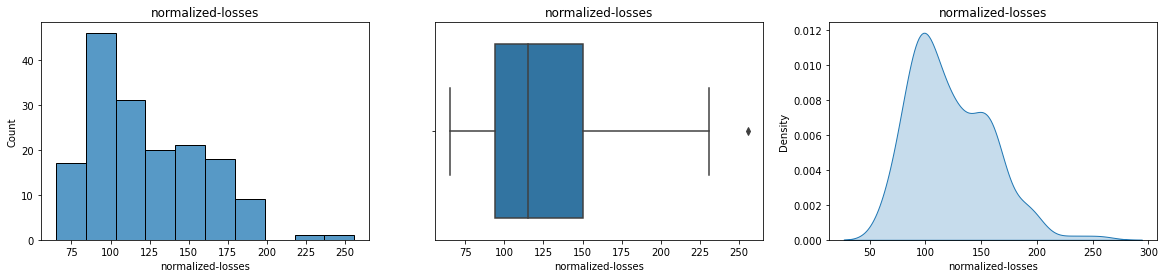

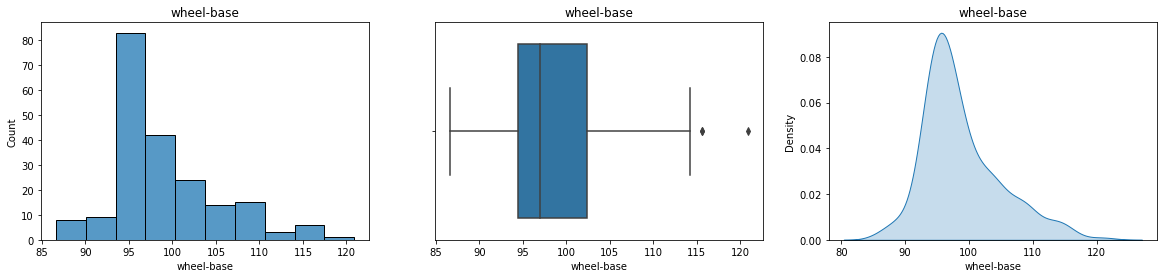

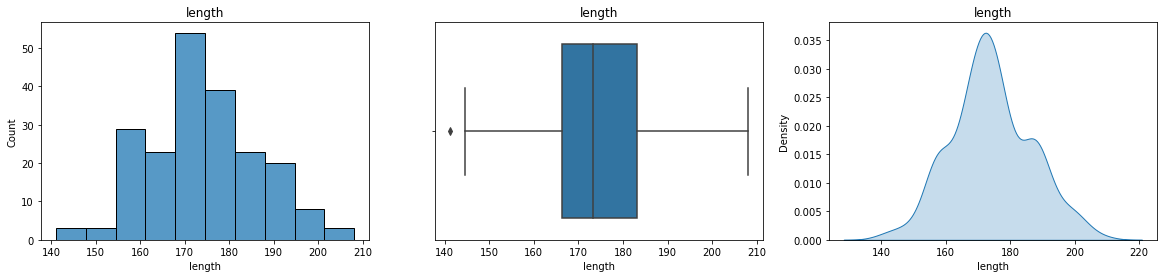

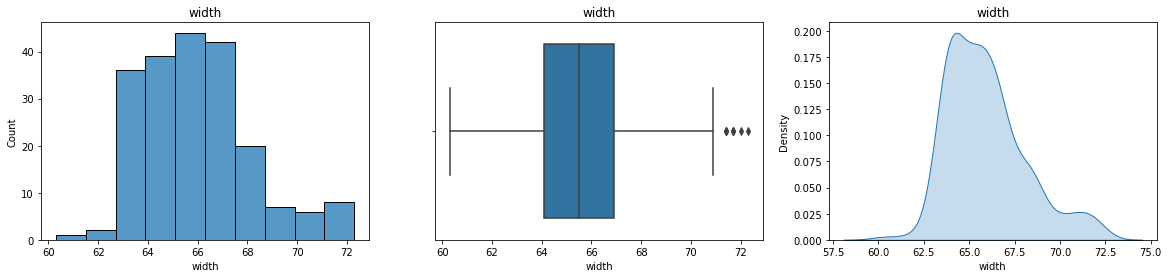

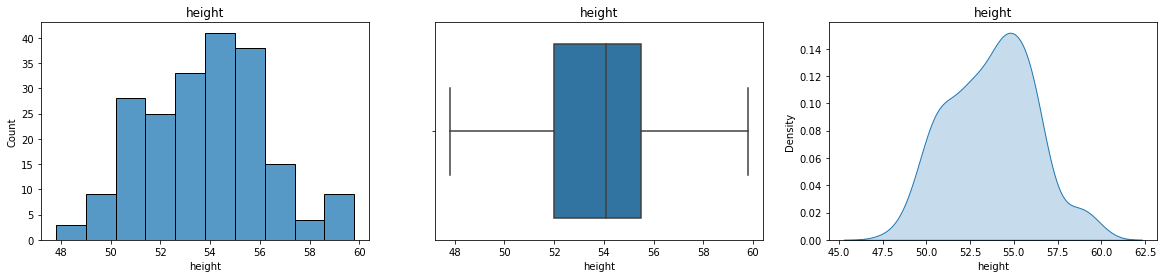

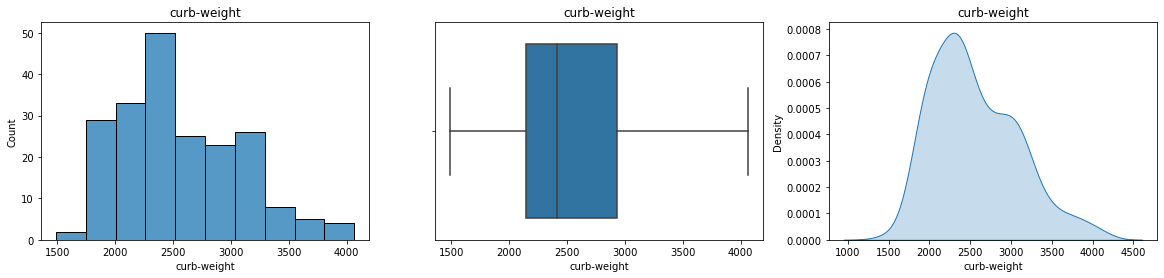

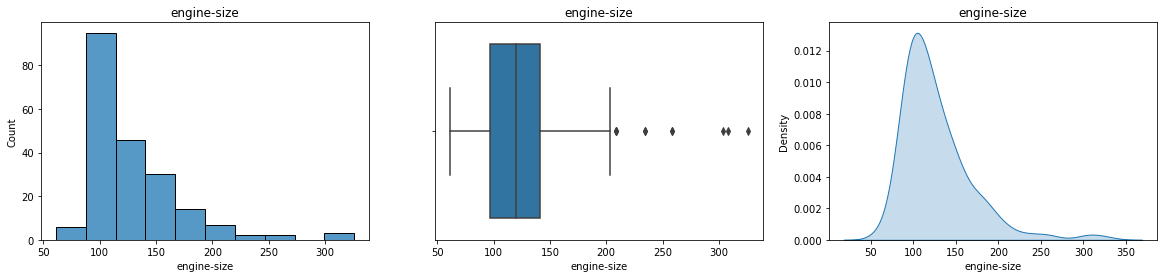

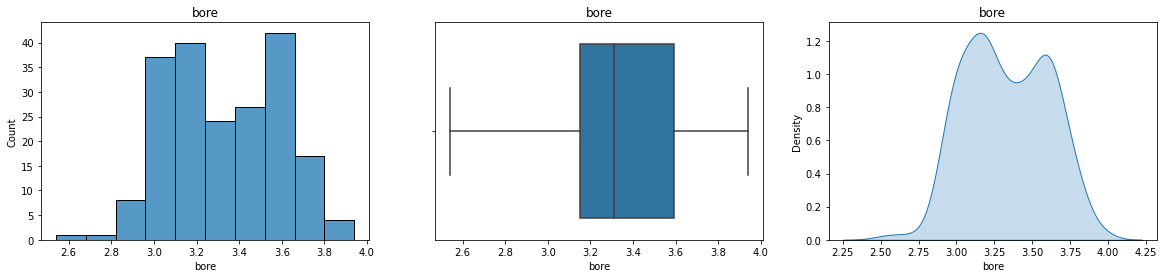

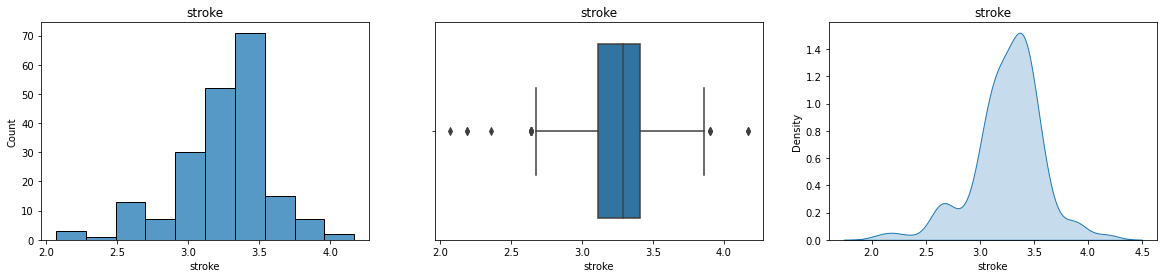

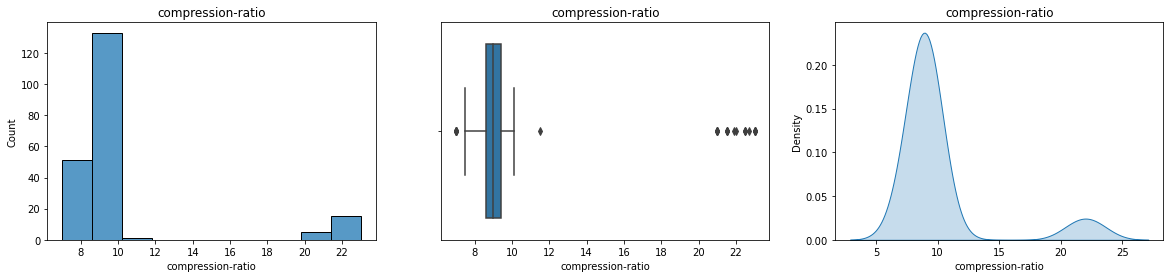

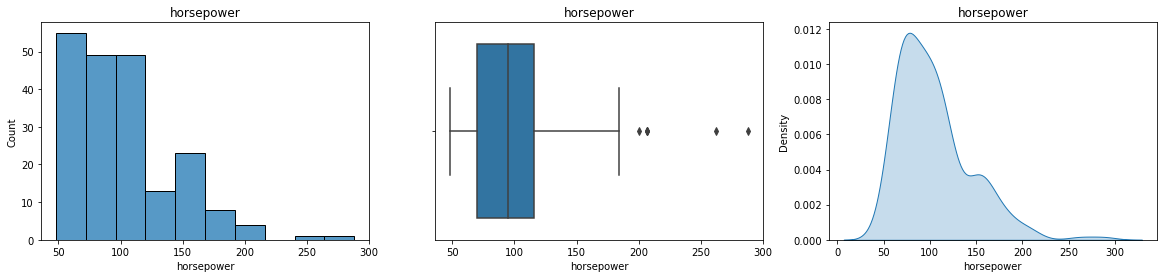

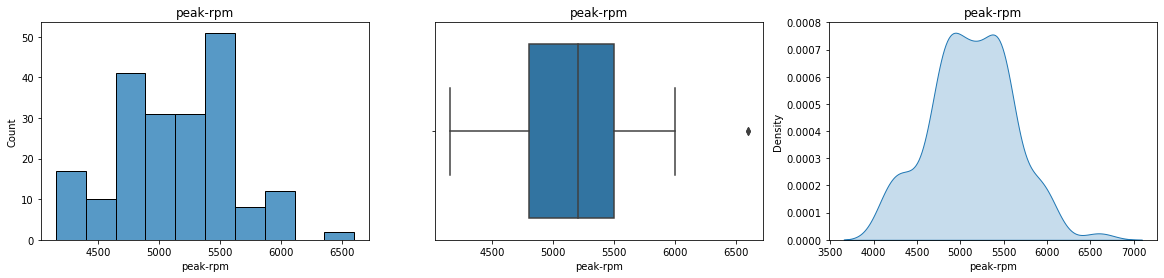

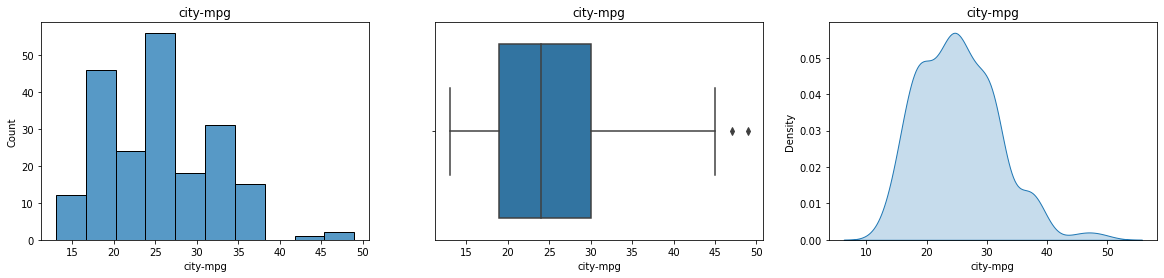

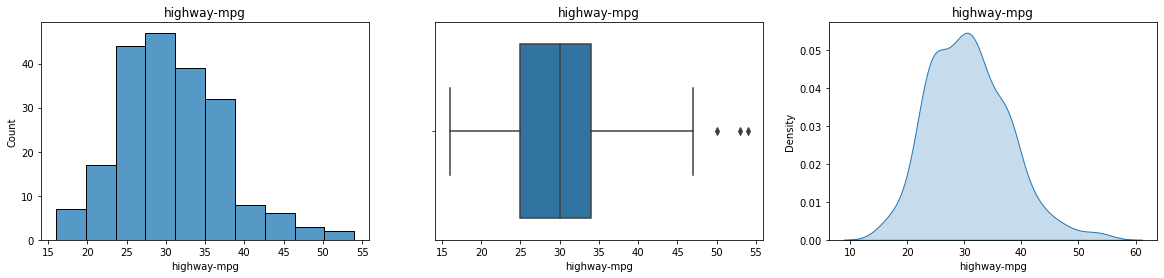

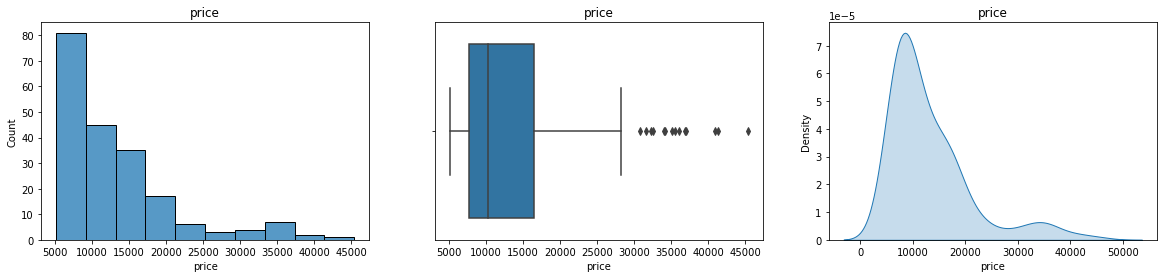

In [60]:
for i in data._get_numeric_data().columns:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    sns.histplot(data[i], bins=10, ax=axes[0])
    axes[0].set_title(i)
    
    sns.boxplot(data[i], ax=axes[1])
    axes[1].set_title(i)
   
    sns.kdeplot(data[i], ax=axes[2],fill=True)
    axes[2].set_title(i)
    plt.show()

# Null Values

In [61]:
data.drop(data[data['price'].isnull()].index,inplace=True)

In [62]:
data.reset_index(inplace=True)

In [63]:
data.drop("index",axis=1,inplace=True)

In [64]:
data.isnull().sum()/len(data)*100
# normalized-losses has null values of 18%, so it should be dropped

symboling             0.000000
normalized-losses    18.407960
make                  0.000000
fuel-type             0.000000
aspiration            0.000000
num-of-doors          0.995025
body-style            0.000000
drive-wheels          0.000000
engine-location       0.000000
wheel-base            0.000000
length                0.000000
width                 0.000000
height                0.000000
curb-weight           0.000000
engine-type           0.000000
num-of-cylinders      0.000000
engine-size           0.000000
fuel-system           0.000000
bore                  1.990050
stroke                1.990050
compression-ratio     0.000000
horsepower            0.995025
peak-rpm              0.995025
city-mpg              0.000000
highway-mpg           0.000000
price                 0.000000
dtype: float64

In [65]:
data.drop("normalized-losses",axis=1,inplace=True)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   make               201 non-null    object 
 2   fuel-type          201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       199 non-null    object 
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    201 non-null    object 
 8   wheel-base         201 non-null    float64
 9   length             201 non-null    float64
 10  width              201 non-null    float64
 11  height             201 non-null    float64
 12  curb-weight        201 non-null    int64  
 13  engine-type        201 non-null    object 
 14  num-of-cylinders   201 non-null    object 
 15  engine-size        201 non-null    int64  
 16  fuel-system        201 non

In [67]:
data['num-of-doors'].value_counts()

four    113
two      86
Name: num-of-doors, dtype: int64

In [68]:
data['num-of-doors'].replace({"four":4,'two':2},inplace=True)

In [69]:
data['num-of-doors'].fillna(data['num-of-doors'].mode()[0],inplace=True)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   make               201 non-null    object 
 2   fuel-type          201 non-null    object 
 3   aspiration         201 non-null    object 
 4   num-of-doors       201 non-null    float64
 5   body-style         201 non-null    object 
 6   drive-wheels       201 non-null    object 
 7   engine-location    201 non-null    object 
 8   wheel-base         201 non-null    float64
 9   length             201 non-null    float64
 10  width              201 non-null    float64
 11  height             201 non-null    float64
 12  curb-weight        201 non-null    int64  
 13  engine-type        201 non-null    object 
 14  num-of-cylinders   201 non-null    object 
 15  engine-size        201 non-null    int64  
 16  fuel-system        201 non

In [71]:
data.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [72]:
data["horsepower"].fillna(data["horsepower"].mean(),inplace=True)
data["bore"].fillna(data["bore"].mean(),inplace=True)
data["stroke"].fillna(data["stroke"].mean(),inplace=True)
data["peak-rpm"].fillna(data["peak-rpm"].mode()[0],inplace=True)

In [73]:
data.isnull().sum()
# no missing values remained

symboling            0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

# Outliers

In [74]:
df=data.copy()

In [75]:
num_cols=data._get_numeric_data().columns

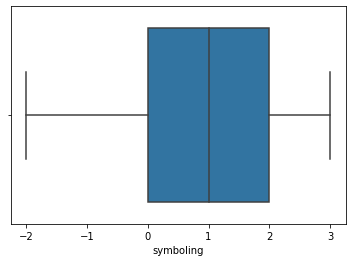

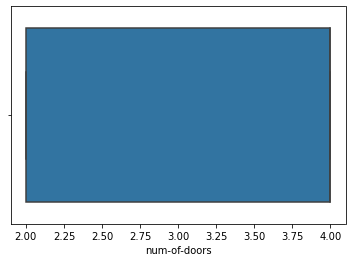

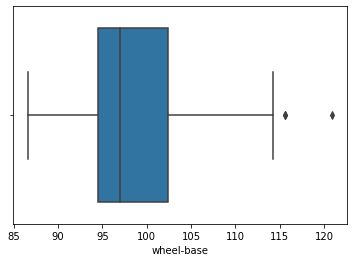

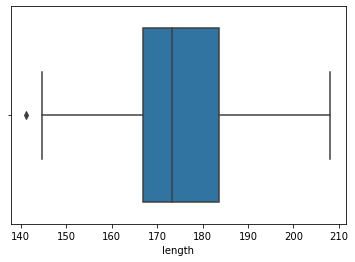

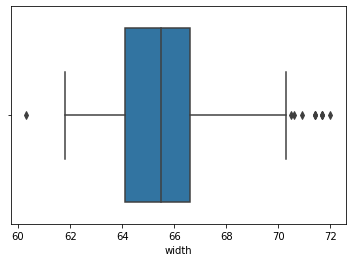

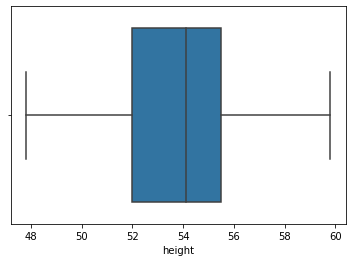

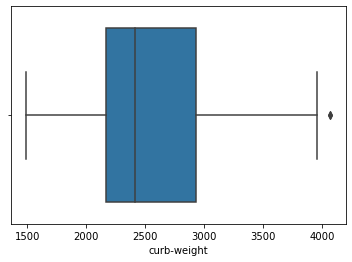

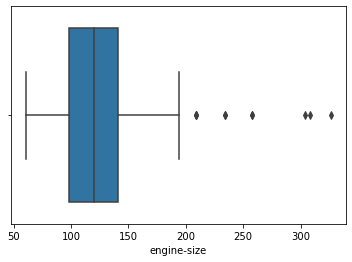

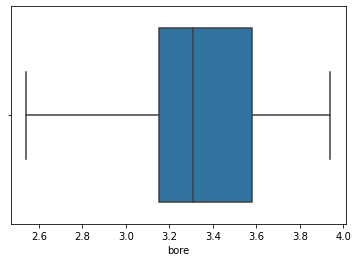

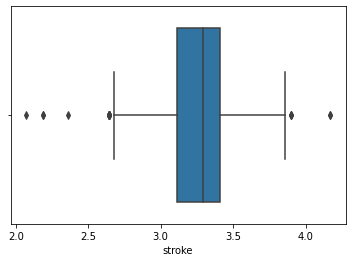

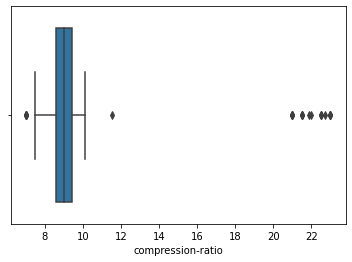

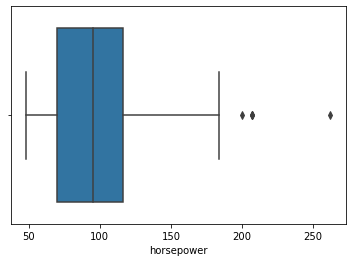

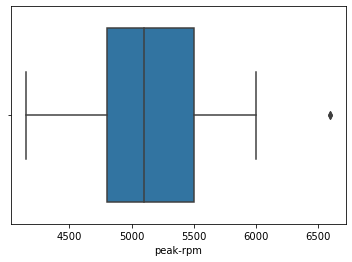

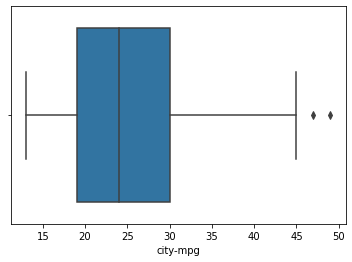

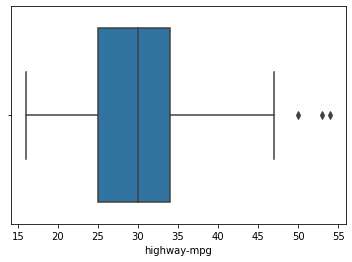

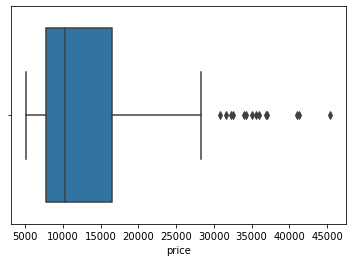

In [76]:
for col in num_cols:
    sns.boxplot(data[col])
    plt.show()

In [77]:
# As it seems, there are plenty of outliers
# Two functions for managing outliers
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, col_name,up=0.25, low=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name,up,low)
    if low_limit > 0:
        dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
    else:
        dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit
        
    return dataframe

In [78]:
# Replacing all outliers except in 'price' column
for col in num_cols[:-1]:
    data=replace_with_thresholds(data,col)

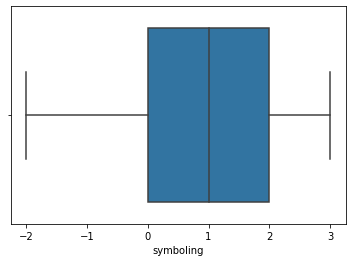

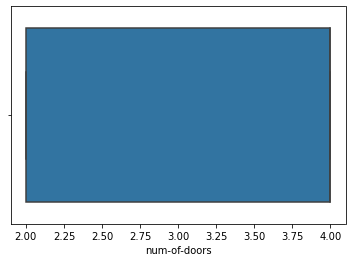

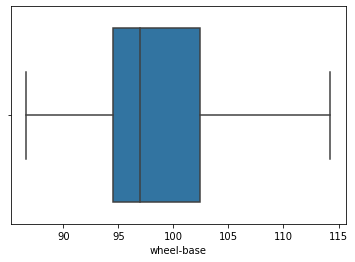

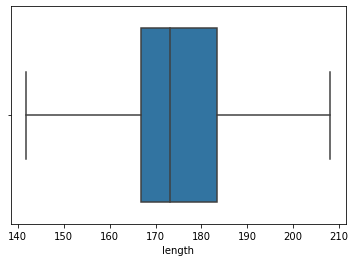

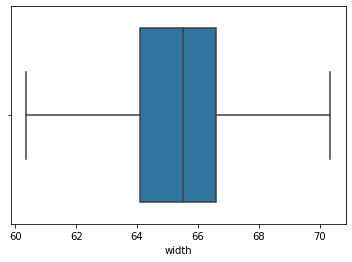

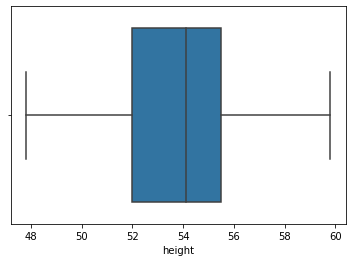

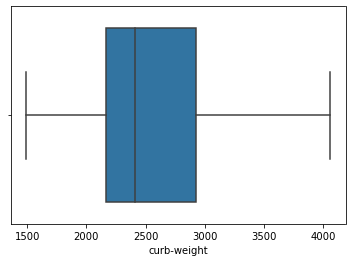

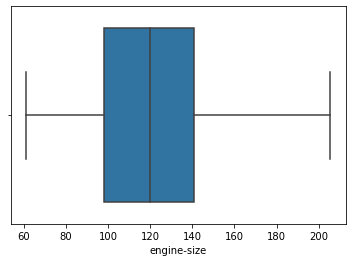

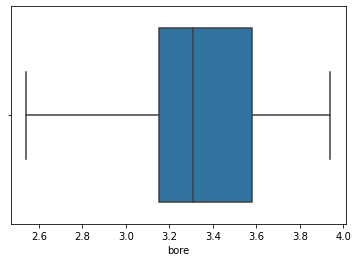

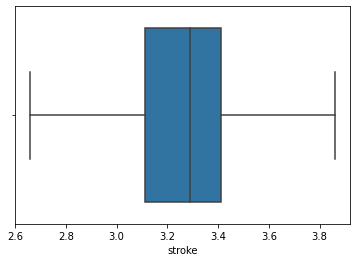

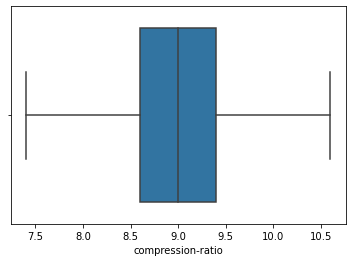

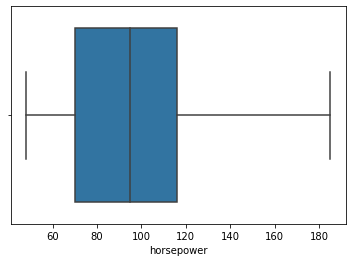

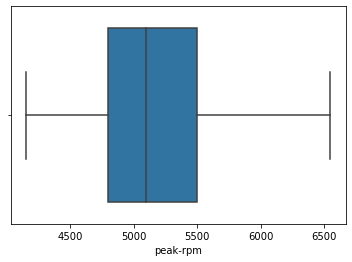

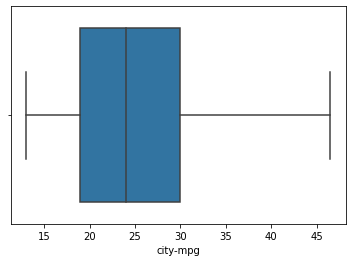

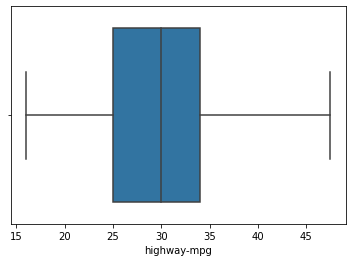

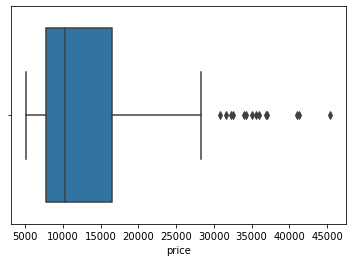

In [79]:
for col in num_cols:
    sns.boxplot(data[col])
    plt.show()

In [80]:
obj_cols=data.select_dtypes("object").columns
obj_cols

Index(['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels',
       'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'],
      dtype='object')

In [81]:
data["make"].value_counts()

toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
subaru           12
volkswagen       12
volvo            11
peugot           11
dodge             9
bmw               8
mercedes-benz     8
plymouth          7
saab              6
audi              6
porsche           4
chevrolet         3
jaguar            3
alfa-romero       3
renault           2
isuzu             2
mercury           1
Name: make, dtype: int64

In [82]:
for col in obj_cols:
    print(data[col].value_counts())
    print("################")
    
# Some values take place less than 5 percentage of the column

toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
subaru           12
volkswagen       12
volvo            11
peugot           11
dodge             9
bmw               8
mercedes-benz     8
plymouth          7
saab              6
audi              6
porsche           4
chevrolet         3
jaguar            3
alfa-romero       3
renault           2
isuzu             2
mercury           1
Name: make, dtype: int64
################
gas       181
diesel     20
Name: fuel-type, dtype: int64
################
std      165
turbo     36
Name: aspiration, dtype: int64
################
sedan          94
hatchback      68
wagon          25
hardtop         8
convertible     6
Name: body-style, dtype: int64
################
fwd    118
rwd     75
4wd      8
Name: drive-wheels, dtype: int64
################
front    198
rear       3
Name: engine-location, dtype: int64
################
ohc      145
ohcf      15
ohcv      13
dohc      12
l         12
roto

# Correlation

In [83]:
# Correlation dataframe of df
corr=data.corr()

In [84]:
# Correlation dataframe of df where correlation is higher than 0.5 (for price)
corr=corr[abs(corr['price'])>0.5]
corr

,symboling,num-of-doors,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
wheel-base,-0.541604,0.449006,1.000000,0.876280,0.813860,0.595586,0.780782,0.558555,0.493476,0.184223,0.018210,0.401299,-0.355467,-0.468984,-0.539633,0.573278
length,-0.365417,0.395095,0.876280,1.000000,0.860803,0.492347,0.880783,0.705506,0.608954,0.144079,-0.052155,0.607080,-0.288739,-0.664495,-0.695930,0.690846
width,-0.245915,0.230741,0.813860,0.860803,1.000000,0.304839,0.874482,0.732845,0.563055,0.213914,-0.032760,0.638229,-0.251649,-0.642562,-0.687819,0.738159
curb-weight,-0.233119,0.208495,0.780782,0.880783,0.874482,0.307693,1.000000,0.864633,0.644107,0.173450,-0.090160,0.772119,-0.278619,-0.751772,-0.801804,0.834400
engine-size,-0.106239,0.041811,0.558555,0.705506,0.732845,0.113993,0.864633,1.000000,0.620213,0.226537,-0.119682,0.839027,-0.258539,-0.684189,-0.705672,0.849061
bore,-0.139896,0.119140,0.493476,0.608954,0.563055,0.180327,0.644107,0.620213,1.000000,-0.089628,-0.125692,0.580519,-0.270462,-0.583228,-0.593658,0.543154
horsepower,0.068271,-0.083649,0.401299,0.607080,0.638229,-0.054019,0.772119,0.839027,0.580519,0.117291,-0.365862,1.000000,0.101604,-0.844706,-0.836481,0.804629
city-mpg,-0.037995,-0.025129,-0.468984,-0.664495,-0.642562,-0.047742,-0.751772,-0.684189,-0.583228,-0.038623,0.468683,-0.844706,-0.112987,1.000000,0.966863,-0.690176
highway-mpg,0.028759,-0.034589,-0.539633,-0.695930,-0.687819,-0.101806,-0.801804,-0.705672,-0.593658,-0.038102,0.428472,-0.836481,-0.055991,0.966863,1.000000,-0.717409
price,-0.082391,0.042435,0.573278,0.690846,0.738159,0.135486,0.834400,0.849061,0.543154,0.065994,-0.087538,0.804629,-0.098123,-0.690176,-0.717409,1.000000


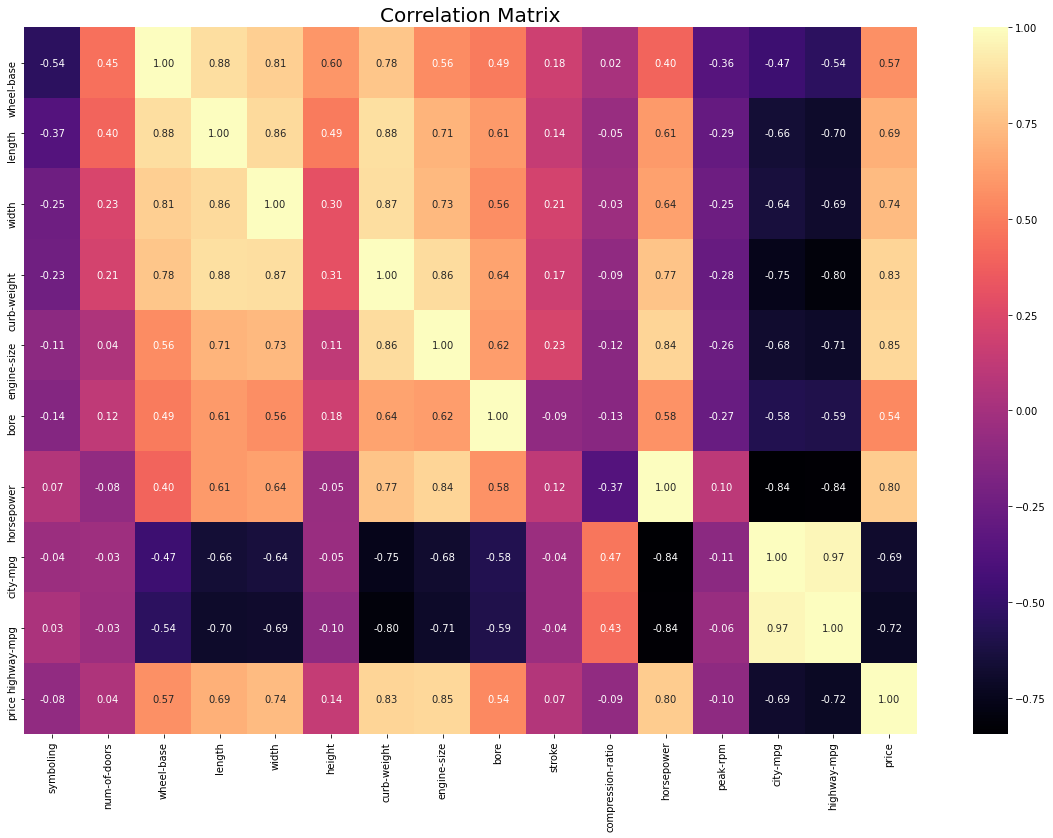

In [85]:
# Correlation matrix of highest corr_rate for price
f, ax = plt.subplots(figsize= [20,13])
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# ML

In [86]:
df=data.copy()

In [87]:
#data=df.copy()

In [88]:
data.describe().T
# Price column has a very large std compared to its mean
# So, price column needs to be normalized

,count,mean,std,min,25%,50%,75%,max
symboling,201.0,0.840796,1.254802,-2.00,0.00,1.00,2.00,3.00
num-of-doors,201.0,3.144279,0.992008,2.00,2.00,4.00,4.00,4.00
wheel-base,201.0,98.750498,5.925743,86.60,94.50,97.00,102.40,114.25
length,201.0,174.204229,12.313527,141.75,166.80,173.20,183.50,208.10
width,201.0,65.840547,1.978493,60.35,64.10,65.50,66.60,70.35
height,201.0,53.766667,2.447822,47.80,52.00,54.10,55.50,59.80
curb-weight,201.0,2555.621891,517.165519,1488.00,2169.00,2414.00,2926.00,4061.50
engine-size,201.0,124.417910,33.498537,61.00,98.00,120.00,141.00,205.50
bore,201.0,3.330711,0.268072,2.54,3.15,3.31,3.58,3.94
stroke,201.0,3.263421,0.278814,2.66,3.11,3.29,3.41,3.86


In [89]:
data=replace_with_thresholds(data,"price")

In [90]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
symboling,201.0,0.840796,1.254802,-2.00,0.00,1.00,2.00,3.00
num-of-doors,201.0,3.144279,0.992008,2.00,2.00,4.00,4.00,4.00
wheel-base,201.0,98.750498,5.925743,86.60,94.50,97.00,102.40,114.25
length,201.0,174.204229,12.313527,141.75,166.80,173.20,183.50,208.10
width,201.0,65.840547,1.978493,60.35,64.10,65.50,66.60,70.35
height,201.0,53.766667,2.447822,47.80,52.00,54.10,55.50,59.80
curb-weight,201.0,2555.621891,517.165519,1488.00,2169.00,2414.00,2926.00,4061.50
engine-size,201.0,124.417910,33.498537,61.00,98.00,120.00,141.00,205.50
bore,201.0,3.330711,0.268072,2.54,3.15,3.31,3.58,3.94
stroke,201.0,3.263421,0.278814,2.66,3.11,3.29,3.41,3.86


In [91]:
df=data.copy()

In [92]:
data=pd.get_dummies(data)

# Modeling

In [93]:
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [94]:
def reg_modeling(df, Y, algo):
    X=df.drop(Y, axis=1)
    Y=df[[Y]]
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, random_state=42)
    model=algo.fit(X_train, Y_train)
    Y_pred=algo.predict(X_test)
    error=np.sqrt(mean_squared_error(Y_test,Y_pred))
    score_algo=algo.score(X_test, Y_test)
    r2=r2_score(Y_test,Y_pred)
    print(f'{type(model).__name__}\n---Error: {error}\n---Algo_Score: {score_algo}\n---R2_Score: {r2}')    
    print('----------------------------------------------------')
    return (type(model).__name__, error,score_algo,r2)

In [95]:
models=[LinearRegression(),Ridge(),Lasso(),ElasticNet()]
results={ 'model_name':[], 'Error':[],"Model_Score":[],"R2_Score":[]}

In [96]:
for m in models:
    res=reg_modeling(data,"price",m)
    results['model_name'].append(res[0])
    results["Error"].append(res[1])
    results["Model_Score"].append(res[2])
    results["R2_Score"].append(res[3])

LinearRegression
---Error: 1774.615478498001
---Algo_Score: 0.960148129358563
---R2_Score: 0.960148129358563
----------------------------------------------------
Ridge
---Error: 1508.0792954078038
---Algo_Score: 0.971220149303935
---R2_Score: 0.971220149303935
----------------------------------------------------
Lasso
---Error: 1720.6638416643875
---Algo_Score: 0.9625344384414201
---R2_Score: 0.9625344384414201
----------------------------------------------------
ElasticNet
---Error: 3410.711125486781
---Algo_Score: 0.8527924593163472
---R2_Score: 0.8527924593163472
----------------------------------------------------


In [97]:
model_parameters={
    'Ridge' : {
        'model': Ridge(),
        'params': {'alpha': [0.1, 0.01, 0.005, 0.05, 0.001 ,0.2, 0.3, 0.5, 0.8, 0.9, 1], 
                   'solver': ['auto', 'svd', 'cholesky']}},
    'Lasso': {
        'model': Lasso(),
        'params': {'selection': ['cyclic', 'random'], 
                  'alpha': [0.1,0.01, 0.005, 0.05, 0.001 ,0.2, 0.3, 0.5, 0.8, 0.9, 1]}},
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                   'splitter': ['best', 'random']}}, 
    'KNeighbors': {
        'model': KNeighborsRegressor(), 
        'params': {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                  'weights': ['uniform', 'distance'],
                  'n_neighbors': [3, 4, 5]}},
    'ElasticNet': {
        'model': ElasticNet(), 
        'params': {'alpha': [0.1,0.01, 0.005, 0.05, 0.001 ,0.2, 0.3, 0.5, 0.8, 0.9, 1],
                  'selection': ['cyclic', 'random']}}
}

In [98]:
def model_tunings(df,Y, model_params):
    X=df.drop(Y, axis=1)
    Y=df[[Y]]
    results=[]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    for model_name, mp in model_params.items():
        clf=GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=True)
        clf.fit(X_train, Y_train)
        Y_train_pred=clf.predict(X_train)
        Y_test_pred=clf.predict(X_test)
        train_error=np.sqrt(mean_squared_error(Y_train, Y_train_pred))
        train_score=clf.score(X_train, Y_train)
        test_error=np.sqrt(mean_squared_error(Y_test, Y_test_pred))
        test_score=clf.score(X_test, Y_test)
        #score_algo=algo.score(X_test, Y_test)
        r2=r2_score(Y_test,Y_test_pred)
        
        print(model_name)
        #print('Train Rmse: {}'.format(train_error))
        #print('Train Score: {}'.format(train_score))
        print('Test Rmse : {}'.format(test_error))
        print('Test Score: {}'.format(test_score))
        print("R2_score  : {}".format(r2))
        print('------------------------------------------------------')
        results.append({'model': model_name, 
                        #'Train Error': train_error,
                        #'Train Score': train_score,
                        'Test Error': test_error,
                        'Test Score': test_score,
                        'best_score': clf.best_score_,
                        'best_params': clf.best_params_})
    return results

In [99]:
tunings=model_tunings(data,'price',model_parameters)

Ridge
Test Rmse : 1539.581779718276
Test Score: 0.9670927928935154
R2_score  : 0.9670927928935154
------------------------------------------------------
Lasso
Test Rmse : 2104.6379122147177
Test Score: 0.9385049331863936
R2_score  : 0.9385049331863936
------------------------------------------------------
Decision Tree
Test Rmse : 1720.5412409369053
Test Score: 0.9589024745573087
R2_score  : 0.9589024745573087
------------------------------------------------------
KNeighbors
Test Rmse : 2548.8166344023516
Test Score: 0.9098091074965919
R2_score  : 0.9098091074965919
------------------------------------------------------
ElasticNet
Test Rmse : 1531.734911398795
Test Score: 0.9674273778909305
R2_score  : 0.9674273778909305
------------------------------------------------------


In [100]:
def light_gbm(df, Y):
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    lgbm=LGBMRegressor()
    X=df.drop(Y, axis=1)
    Y=df[[Y]]
    X_train, X_test, Y_train, Y_test=train_test_split(X, Y, random_state=42, test_size=0.20)
    lgbm.fit(X_train, Y_train)

    Y_pred=lgbm.predict(X_test,num_iteration=lgbm.best_iteration_)
    print("Light_Score:: ",lgbm.score(X_test,Y_test))
    print("Error:: ",(np.sqrt(mean_squared_error(Y_test, Y_pred))))
    print("R2_Score:: ",(r2_score(Y_test,Y_pred)))
    #print(Y_pred)
    return Y_pred

In [101]:
Y_pred=light_gbm(data,"price")

Light_Score::  0.9121752870676039
Error::  2634.439798715908
R2_Score::  0.9121752870676039


In [102]:
def light_gbm_tuning(df, Y):
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X=df.drop(Y, axis=1)
    Y=df[[Y]]
    X_train, X_test, Y_train, Y_test=train_test_split(X, Y, random_state=42, test_size=0.20)
    lgbm_grid={
    'colsample_bytree':[0.4, 0.5, 0.6, 0.9, 1],
    'learning_rate':[0.01, 0.1, 0.5, 1],
           'n_estimators':[20, 40, 100, 200, 500, 1000],
           'max_depth':[1, 2, 3, 4, 5, 6, 7, 8]}

    lgbm=LGBMRegressor()

    lgbm_cv_model=GridSearchCV(lgbm, lgbm_grid, cv=10,
                           n_jobs=-1, verbose=2)

    lgbm_cv_model.fit(X_train, Y_train)

    print("Parameters:: ",lgbm_cv_model.best_params_)
    print("Score::      ",lgbm_cv_model.best_score_)
    return lgbm_cv_model.best_params_,lgbm_cv_model.best_score_

In [103]:
params,light_score=light_gbm_tuning(data,"price")

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9376 tasks      | elapsed:  2.8min


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Parameters::  {'colsample_bytree': 0.4, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 200}
Score::       0.8261486761257248


[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  2.9min finished


In [104]:
light_score

0.8261486761257248

In [105]:
##############################

In [106]:
##############################

Best result so far is below::

model: ElasticNet (GridSearch CV tuning)    

***Test Rmse : 1531.7349767798682***                                                                                           

***Test Score: 0.9674273751102496***       

***R2_score  : 0.9674273751102496***
